In [124]:
import numpy
import collections
from tensorflow.python.framework import dtypes

from os import listdir
import os
from os.path import isfile, join
import numpy as np
import cv2

import matplotlib.pylab as plt
%matplotlib inline

from __future__ import division
from __future__ import print_function

import argparse
import sys

import glob

import tensorflow as tf

In [19]:
###From https://gist.github.com/ambodi/408301bc5bc07bc5afa8748513ab9477#file-dataset-py-L74

In [20]:
###Data from  https://www.kaggle.com/c/dogs-vs-cats/data

## Saving raw data to npy

#### Load data Methode 1

In [161]:
#path to directory
path_train = 'raw_data/train/'
path_test = 'raw_data/test/'

#get folder names
def directory_scan(path):
    dirlist = [ item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item)) ]
    return dirlist

#build labels and image arrays, resize image to 100*100
def read_images_in_folder(dirlist, path):
    images=[]
    labels = []
    count = 0
    for i in range(len(dirlist)):
        image_stack = []
        for img in glob.glob(path+dirlist[i]+'/*jpg'):
            count=count+1
            labels.append(dirlist[i])
            IMG = cv2.imread(img)
            #RGB to grey scale
            IMG_2= cv2.cvtColor( IMG, cv2.COLOR_RGB2GRAY )
            #resize to 100*100
            im_resize = cv2.resize(IMG_2, (100, 100), interpolation=cv2.INTER_CUBIC)
            images.append(im_resize)
        #np_images = np.array(image_stack)
        
    return images, labels, count

if __name__ == '__main__':
    dirlist_train = directory_scan(path_train)
    images_train,labels_train,count_train = read_images_in_folder(dirlist_train, path_train)
    dirlist_test = directory_scan(path_test)
    images_test,labels_test,count_test = read_images_in_folder(dirlist_test, path_test)

#save to file
np.save('npy/images_train',images_train)
np.save('npy/labels_train',labels_train)
np.save('npy/images_test',images_test)
np.save('npy/labels_test',labels_test)

print('There are '+ str(count_train) +' training images')
print('There are '+ str(count_test) +' testing images')

There are 1400 training images
There are 40 testing images


'cat'

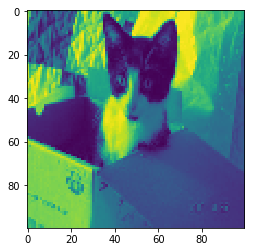

In [165]:
#LOAD TRAIN
#load images
train_images = np.load('npy/images_train.npy')
plt.imshow(IMG[100])

#load labels
train_labels = np.load('npy/labels_train.npy')
LABELS[1]

#LOAD TEST
#load images
test_images = np.load('npy/images_test.npy')
plt.imshow(IMG[100])

#load labels
test_labels = np.load('npy/labels_test.npy')
LABELS[1]

#### Load data Methode 2

In [133]:
#get file path
dirlist = [ item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item)) ]

for i in range(len(dirlist)):
    filenames = []
    for img in glob.glob('raw_data/train/'+dirlist[i]+'/*jpg'):
        filenames.append(img)
            
print(filenames)

['raw_data/train/dog\\dog.12480.jpg', 'raw_data/train/dog\\dog.12481.jpg', 'raw_data/train/dog\\dog.12482.jpg', 'raw_data/train/dog\\dog.12483.jpg', 'raw_data/train/dog\\dog.12484.jpg', 'raw_data/train/dog\\dog.12485.jpg', 'raw_data/train/dog\\dog.12486.jpg', 'raw_data/train/dog\\dog.12487.jpg', 'raw_data/train/dog\\dog.12488.jpg', 'raw_data/train/dog\\dog.12489.jpg', 'raw_data/train/dog\\dog.12490.jpg', 'raw_data/train/dog\\dog.12491.jpg', 'raw_data/train/dog\\dog.12492.jpg', 'raw_data/train/dog\\dog.12493.jpg', 'raw_data/train/dog\\dog.12494.jpg', 'raw_data/train/dog\\dog.12495.jpg', 'raw_data/train/dog\\dog.12496.jpg', 'raw_data/train/dog\\dog.12497.jpg', 'raw_data/train/dog\\dog.12498.jpg', 'raw_data/train/dog\\dog.12499.jpg']


In [123]:
dirlist = [ item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item)) ]

for i in range(len(dirlist)):
    filenames = []
    for img in glob.glob('raw_data/train/'+dirlist[i]+'/*jpg'):
        filenames.append(img)

# step 1
#filenames = ['im_01.jpg', 'im_02.jpg', 'im_03.jpg', 'im_04.jpg']

# step 2: create a dataset returning slices of `filenames`
dataset = tf.data.Dataset.from_tensor_slices(filenames)

# step 3: parse every image in the dataset using `map`
def _parse_function(filename):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image

dataset = dataset.map(_parse_function)
dataset = dataset.batch(2)

# step 4: create iterator and final input tensor
iterator = dataset.make_one_shot_iterator()
images = iterator.get_next()

AttributeError: module 'tensorflow' has no attribute 'data'

## Preparing Data for Model

In [85]:
"""A generic module to read data."""


class DataSet(object):
    """Dataset class object."""

    def __init__(self,
                 images,
                 labels,
                 fake_data=False,
                 one_hot=False,
                 dtype=dtypes.float64,
                 reshape=True):
        """Initialize the class."""
        if reshape:
            assert images.shape[3] == 1
            images = images.reshape(images.shape[0],
                images.shape[1] * images.shape[2])

        self._images = images
        self._num_examples = images.shape[0]
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size, fake_data=False):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Shuffle the data
            perm = numpy.arange(self._num_examples)
            numpy.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end]


def read_data_sets(train_dir, fake_data=False, one_hot=False,
                        dtype=dtypes.float64, reshape=True,
                        validation_size=5000):
    """Set the images and labels."""
    num_training = 3000
    num_validation = 1000
    num_test = 1000

    all_images = numpy.load('./npy/images.npy')
    all_images = all_images.reshape(all_images.shape[0],
        all_images.shape[1], all_images.shape[2], 1)

    train_labels_original = numpy.load('./npy/label.npy')
    all_labels = numpy.asarray(range(0, len(train_labels_original)))
    all_labels = dense_to_one_hot(all_labels, len(all_labels))

    mask = range(num_training)
    train_images = all_images[mask]
    train_labels = all_labels[mask]

    mask = range(num_training, num_training + num_validation)
    validation_images = all_images[mask]
    validation_labels = all_labels[mask]

    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    test_images = all_images[mask]
    test_labels = all_labels[mask]

    train = DataSet(train_images, train_labels, dtype=dtype, reshape=reshape)
    validation = DataSet(validation_images, validation_labels, dtype=dtype,
        reshape=reshape)

    test = DataSet(test_images, test_labels, dtype=dtype, reshape=reshape)
    ds = collections.namedtuple('Datasets', ['train', 'validation', 'test'])

    return ds(train=train, validation=validation, test=test)



def dense_to_one_hot(labels_dense, num_classes):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = numpy.arange(num_labels) * num_classes
    labels_one_hot = numpy.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1

    return labels_one_hot

## Run Model on Data

In [186]:
from keras import models
from keras import layers

#initializes the model
network = models.Sequential()

#512 > nb of neurons. 28*28 > size of input
network.add(layers.Dense(512, activation='relu', input_shape=(100 * 100,)))
# 10 > nb of neurons in second layer
network.add(layers.Dense(512, activation='softmax'))

In [187]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [188]:
#prepare and reshape testing/training sets
img_size = 100
nb_img_train = 1400
nb_img_test = 40

train_images = train_images.reshape((nb_img_train, img_size * img_size))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((nb_img_test, img_size * img_size))
test_images = test_images.astype('float32') / 255

In [193]:
#ONE HOT ENCODE LABELS
ind = [0]
for i in range(len(dirlist)):
    ind.append(i)

Train_labs = tf.one_hot(indices=ind, depth=1400)

In [192]:
network.fit(train_images, Train_labs, epochs=5, batch_size=128)

ValueError: Error when checking target: expected dense_6 to have shape (None, 512) but got array with shape (3, 1400)

In [ ]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

In [ ]:
print('test_acc:', test_acc, 'test_loss', test_loss)

In [87]:
FLAGS = None

import dataset


def main(_):
    """Run the NN."""
    mnist = dataset.read_data_sets(FLAGS.data_dir, one_hot=True)

    x = tf.placeholder(tf.float32, [None, 10000])
    w = tf.Variable(tf.zeros([10000, 5000]))
    b = tf.Variable(tf.zeros([5000]))
    y = tf.matmul(x, w) + b

    # Define loss and optimizer
    y_ = tf.placeholder(tf.float32, [None, 5000])
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y,y_))
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()
    
    # Train
    for _ in range(1000):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        print(batch_xs.shape)
        print(batch_ys.shape)
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    # Test trained model
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict={x: mnist.test.images,
                                        y_: mnist.test.labels}))

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='/tmp/tensorflow/mnist/ \
        input_data', help='Directory for storing input data')
    FLAGS, unparsed = parser.parse_known_args()
    tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

ImportError: No module named 'dataset'